In [1]:
from ecnet.datasets import load_cn, load_lhv, load_ysi

smiles_cn, cn = load_cn()
smiles_lhv, lhv = load_lhv()
_smiles_ysi, _ysi = load_ysi()

smiles_ysi, ysi = [], []
for i in range(len(_smiles_ysi)):
    if _ysi[i][0] < 300:
        smiles_ysi.append(_smiles_ysi[i])
        ysi.append(_ysi[i])

In [2]:
from sklearn.model_selection import train_test_split

smiles_cn_train, smiles_cn_test, cn_train, cn_test = train_test_split(smiles_cn, cn, test_size=0.2, random_state=24)
smiles_lhv_train, smiles_lhv_test, lhv_train, lhv_test = train_test_split(smiles_lhv, lhv, test_size=0.2, random_state=24)
smiles_ysi_train, smiles_ysi_test, ysi_train, ysi_test = train_test_split(smiles_ysi, ysi, test_size=0.2, random_state=24)

In [3]:
from ecnet.datasets import QSPRDataset

ds_cn_train = QSPRDataset(smiles_cn_train, cn_train, backend='alvadesc')
ds_cn_test = QSPRDataset(smiles_cn_test, cn_test, backend='alvadesc')
ds_lhv_train = QSPRDataset(smiles_lhv_train, lhv_train, backend='alvadesc')
ds_lhv_test = QSPRDataset(smiles_lhv_test, lhv_test, backend='alvadesc')
ds_ysi_train = QSPRDataset(smiles_ysi_train, ysi_train, backend='alvadesc')
ds_ysi_test = QSPRDataset(smiles_ysi_test, ysi_test, backend='alvadesc')

In [4]:
from sklearn.decomposition import PCA
import torch

pca_cn = PCA(n_components=len(ds_cn_train))
pca_lhv = PCA(n_components=len(ds_lhv_train))
pca_ysi = PCA(n_components=len(ds_ysi_train))

pca_cn.fit(ds_cn_train.desc_vals.detach().numpy())
pca_lhv.fit(ds_lhv_train.desc_vals.detach().numpy())
pca_ysi.fit(ds_ysi_train.desc_vals.detach().numpy())

ds_cn_train.desc_vals = torch.tensor(pca_cn.transform(ds_cn_train.desc_vals.detach().numpy())).type(torch.float32)
ds_cn_test.desc_vals = torch.tensor(pca_cn.transform(ds_cn_test.desc_vals.detach().numpy())).type(torch.float32)
ds_lhv_train.desc_vals = torch.tensor(pca_lhv.transform(ds_lhv_train.desc_vals.detach().numpy())).type(torch.float32)
ds_lhv_test.desc_vals = torch.tensor(pca_lhv.transform(ds_lhv_test.desc_vals.detach().numpy())).type(torch.float32)
ds_ysi_train.desc_vals = torch.tensor(pca_ysi.transform(ds_ysi_train.desc_vals.detach().numpy())).type(torch.float32)
ds_ysi_test.desc_vals = torch.tensor(pca_ysi.transform(ds_ysi_test.desc_vals.detach().numpy())).type(torch.float32)

In [5]:
from ecnet.model import load_model

model_cn = load_model('models/cn_0.pt')
model_lhv = load_model('models/lhv_0.pt')
model_ysi = load_model('models/ysi_0.pt')

pred_cn_train = model_cn(ds_cn_train.desc_vals).detach().numpy()
pred_cn_test = model_cn(ds_cn_test.desc_vals).detach().numpy()
pred_lhv_train = model_lhv(ds_lhv_train.desc_vals).detach().numpy()
pred_lhv_test = model_lhv(ds_lhv_test.desc_vals).detach().numpy()
pred_ysi_train = model_ysi(ds_ysi_train.desc_vals).detach().numpy()
pred_ysi_test = model_ysi(ds_ysi_test.desc_vals).detach().numpy()

In [6]:
from sklearn.metrics import median_absolute_error, r2_score

mae_cn_train = median_absolute_error(cn_train, pred_cn_train)
mae_cn_test = median_absolute_error(cn_test, pred_cn_test)
r2_cn_train = r2_score(cn_train, pred_cn_train)
r2_cn_test = r2_score(cn_test, pred_cn_test)

mae_lhv_train = median_absolute_error(lhv_train, pred_lhv_train)
mae_lhv_test = median_absolute_error(lhv_test, pred_lhv_test)
r2_lhv_train = r2_score(lhv_train, pred_lhv_train)
r2_lhv_test = r2_score(lhv_test, pred_lhv_test)

mae_ysi_train = median_absolute_error(ysi_train, pred_ysi_train)
mae_ysi_test = median_absolute_error(ysi_test, pred_ysi_test)
r2_ysi_train = r2_score(ysi_train, pred_ysi_train)
r2_ysi_test = r2_score(ysi_test, pred_ysi_test)

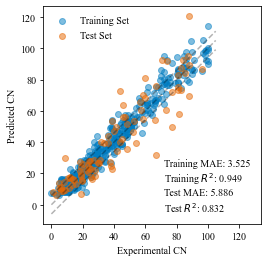

In [7]:
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText

min_val = min(cn_train)[0] - 0.05 * min(cn_train)[0]
max_val = max(cn_train)[0] + 0.05 * max(cn_train)[0]

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Experimental CN')
plt.ylabel('Predicted CN')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + mae_cn_test, max_val + mae_cn_test], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - mae_cn_test, max_val - mae_cn_test], 'k--', alpha=0.3)
plt.scatter(cn_train, pred_cn_train, label='Training Set', alpha=0.5, color=(0, 114/235, 178/235))
plt.scatter(cn_test, pred_cn_test, label='Test Set', alpha=0.5, color=(213/235, 94/235, 0))
plt.legend(loc='upper left', edgecolor='w')
text = 'Training MAE: {:.3f}'.format(mae_cn_train)
text += '\nTraining $R^2$: {:.3f}'.format(r2_cn_train)
text += '\nTest MAE: {:.3f}'.format(mae_cn_test)
text += '\nTest $R^2$: {:.3f}'.format(r2_cn_test)
textbox = AnchoredText(text, frameon=True, loc=4, pad=0.5)
plt.setp(textbox.patch, facecolor='w', edgecolor='w', alpha=0.0)
plt.gca().add_artist(textbox)
plt.axis('square')
plt.savefig('parity_cn.png', dpi=200)
plt.show()

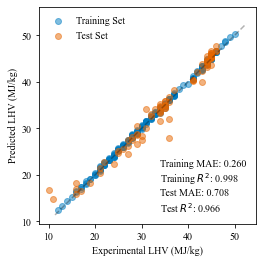

In [8]:
min_val = min(lhv_train)[0] - 0.05 * min(lhv_train)[0]
max_val = max(lhv_train)[0] + 0.05 * max(lhv_train)[0]

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Experimental LHV (MJ/kg)')
plt.ylabel('Predicted LHV (MJ/kg)')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.scatter(lhv_train, pred_lhv_train, label='Training Set', alpha=0.5, color=(0, 114/235, 178/235))
plt.scatter(lhv_test, pred_lhv_test, label='Test Set', alpha=0.5, color=(213/235, 94/235, 0))
plt.legend(loc='upper left', edgecolor='w')
text = 'Training MAE: {:.3f}'.format(mae_lhv_train)
text += '\nTraining $R^2$: {:.3f}'.format(r2_lhv_train)
text += '\nTest MAE: {:.3f}'.format(mae_lhv_test)
text += '\nTest $R^2$: {:.3f}'.format(r2_lhv_test)
textbox = AnchoredText(text, frameon=True, loc=4, pad=0.5)
plt.setp(textbox.patch, facecolor='w', edgecolor='w', alpha=0.0)
plt.gca().add_artist(textbox)
plt.axis('square')
plt.savefig('parity_lhv.png', dpi=200)
plt.show()

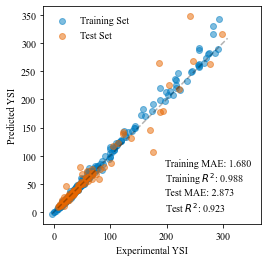

In [9]:
min_val = min(ysi_train)[0] - 0.05 * min(ysi_train)[0]
max_val = max(ysi_train)[0] + 0.05 * max(ysi_train)[0]

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Experimental YSI')
plt.ylabel('Predicted YSI')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.scatter(ysi_train, pred_ysi_train, label='Training Set', alpha=0.5, color=(0, 114/235, 178/235))
plt.scatter(ysi_test, pred_ysi_test, label='Test Set', alpha=0.5, color=(213/235, 94/235, 0))
plt.legend(loc='upper left', edgecolor='w')
text = 'Training MAE: {:.3f}'.format(mae_ysi_train)
text += '\nTraining $R^2$: {:.3f}'.format(r2_ysi_train)
text += '\nTest MAE: {:.3f}'.format(mae_ysi_test)
text += '\nTest $R^2$: {:.3f}'.format(r2_ysi_test)
textbox = AnchoredText(text, frameon=True, loc=4, pad=0.5)
plt.setp(textbox.patch, facecolor='w', edgecolor='w', alpha=0.0)
plt.gca().add_artist(textbox)
plt.axis('square')
plt.savefig('parity_ysi.png', dpi=200)
plt.show()